In [193]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
import pmdarima as pm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VARMAX
from tslearn.clustering import TimeSeriesKMeans

Data Loading and Formatting

In [221]:
global STATE
STATE = "Utah"

global PERIOD
PERIOD =12

global TRAIN_SIZE
TRAIN_SIZE = .75

Use classical decomposition to break down and analyze different features of the housing data for one state.

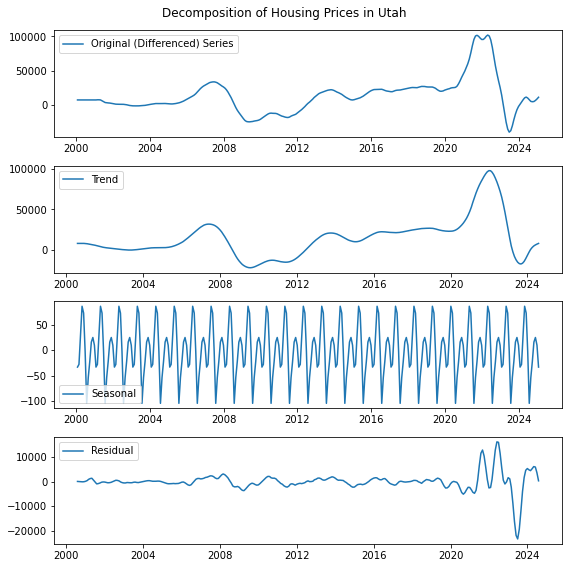

In [222]:
df = pd.read_csv("Data_Files/price_by_state_cleaned.csv")

# convert the month column to datetime format and set it as the index of the dataframe
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index(['Unnamed: 0'], inplace=True)

# difference the data
df = df.diff(periods=PERIOD)
df.fillna(method='backfill', inplace=True)

# identify seasonal component
result = seasonal_decompose(df[STATE], model='additive', period=PERIOD)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# plot the decomposed components
plt.figure(figsize=(8,8))
plt.subplot(4, 1, 1)
plt.plot(df[STATE], label="Original (Differenced) Series")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label="Trend")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label="Seasonal")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label="Residual")
plt.legend()

plt.suptitle(f"Decomposition of Housing Prices in {STATE}")
plt.tight_layout()
plt.show()

SARIMAX Model Fitting

In [223]:
df = pd.read_csv("Data_Files/price_by_state_cleaned.csv")

# convert the month column to datetime format and set it as the index of the dataframe
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index(['Unnamed: 0'], inplace=True)
# create an exogenous variable
df['month_index'] = df.index.month

# split the data into a 70-30 train-test split
# only train and predict data up to 2020 -- things get crazy after that
dates = df.index.tolist()
dates = [date for date in dates if date.year < 2020]
df = df.loc[dates]

n = len(dates)
train_size = int(TRAIN_SIZE * n)
train_dates = dates[:train_size]
test_dates = dates[train_size:]
train_df = df.loc[train_dates]
test_df = df.loc[test_dates]

In [224]:
# initialize model
SARIMAX_model = pm.auto_arima(train_df[[STATE]], exogenous=train_df[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=12, max_q=12,
                              m=PERIOD,
                              start_P=0, seasonal=True,
                              d=None, D=1, 
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

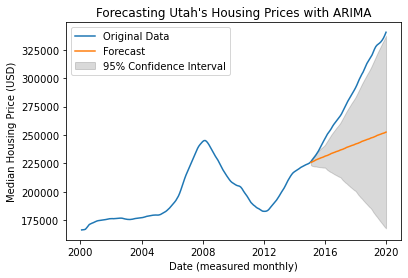

In [225]:
# use the trained model to 
n_periods = len(test_df)
forecast, confint = SARIMAX_model.predict(n_periods=n_periods, exogenous=test_df[["month_index"]], return_conf_int=True)
lower_series = pd.Series(confint[:, 0], index=test_dates)
upper_series = pd.Series(confint[:, 1], index=test_dates)

plt.plot(df[STATE], label="Original Data")
plt.plot(forecast, label="Forecast")
plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15, label="95% Confidence Interval")
plt.legend()
plt.xlabel("Date (measured monthly)")
plt.ylabel("Median Housing Price (USD)")
plt.title(f"Forecasting {STATE}'s Housing Prices with ARIMA")
plt.show()

In [208]:
SARIMAX_model.aic()

2147.535318114047

VARMAX Models

1. Varmax model, clusters by state

First, get clusters of state housing markets.

In [213]:
global N_CLUSTERS
N_CLUSTERS = 7

global CLUSTER_NUM
CLUSTER_NUM = 4

In [214]:
df = pd.read_csv('Data_Files/price_by_state_cleaned.csv')

df = df[df['Unnamed: 0'] < '2020-01-31']
split_date = '2015-01-31'  # Choose the date where to split the data
train = df[df['Unnamed: 0'] < split_date]
train = train.drop(columns=['Unnamed: 0'])
test = df[df['Unnamed: 0'] >= split_date]
test = test.drop(columns=['Unnamed: 0'])

# find difference before transposing
train = train.pct_change()
# print(train)
train = train.values.T
train = train[:, 1:]

# Kmeans with i clusters
km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, max_iter=1000, random_state=0)
pred = km.fit_predict(train)

state_names = df.columns.tolist()[1:]
plot_df = pd.DataFrame({
    "State": state_names,
    "Number": pred
})

# compute cluster
cluster = {}
for i in range(N_CLUSTERS):
    state_with_ = plot_df[plot_df["Number"] == i]["State"]
    cluster[i] = state_with_.values.tolist()

# Convert group_data to DataFrame
grouped_states = []
for group, states in cluster.items():
    for state in states:
        grouped_states.append({'Group': group, 'State': state.lower()})

grouped_df = pd.DataFrame(grouped_states)
grouped_df["State"] = grouped_df["State"].str.title()

In [220]:
grouped_df

,Group,State
0,0,Texas
1,0,Pennsylvania
2,0,Ohio
3,0,North Carolina
4,0,Tennessee
5,0,Indiana
6,0,Missouri
7,0,Wisconsin
8,0,Colorado
9,0,South Carolina


In [231]:
# get list of all the states in the cluster
states_in_cluster = grouped_df[grouped_df["Group"] == CLUSTER_NUM]["State"].values


# convert the month column to datetime format and set it as the index of the dataframe
df = pd.read_csv('Data_Files/price_by_state_cleaned.csv')
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index(['Unnamed: 0'], inplace=True)

# difference the data
df = df.diff(periods=PERIOD)
df.fillna(method='backfill', inplace=True)

# df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
# df.set_index(['Unnamed: 0'], inplace=True)
# # split the data into a 70-30 train-test split
# # only train and predict data up to 2020 -- things get crazy after that
# dates = df.index.tolist()
# dates = [date for date in dates if date.year < 2020]
df = df.loc[dates]

# n = len(dates)
# train_size = int(TRAIN_SIZE * n)
# train_dates = dates[:train_size]
# test_dates = dates[train_size:]
# train = df.loc[train_dates]
# test = df.loc[test_dates]

cluster_df = df[states_in_cluster]
cluster_df = cluster_df.loc[train_dates]

In [216]:
print(states_in_cluster)

['Georgia' 'Michigan' 'Washington' 'Oregon' 'Utah' 'Idaho']


In [217]:
# initialize and fit model
VARMAX_model = VARMAX(cluster_df)       # WHAT DO WE USE AS THE FREQUENCY??
VARMAX_model = VARMAX_model.fit(maxiter=1000, disp=False)

/home/tiaraedd/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/tiaraedd/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


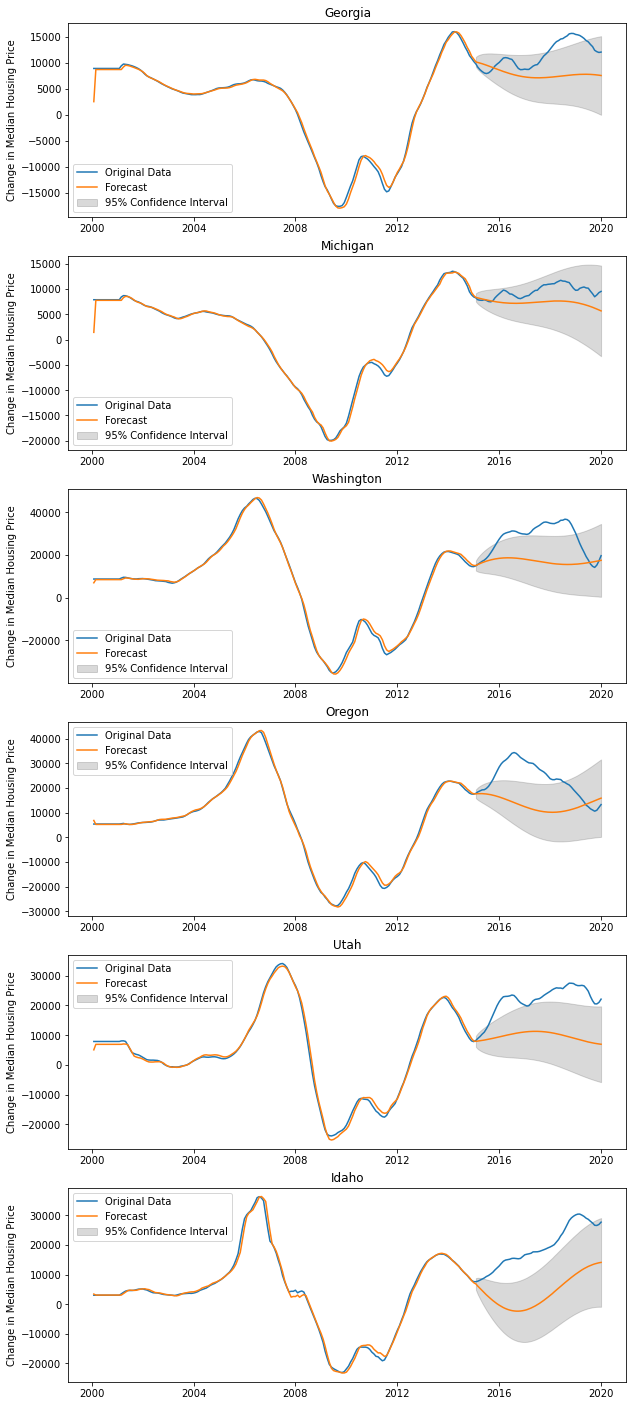

In [233]:
start = dates[0]
end = dates[-1]
# end = datetime(end.year + 3, end.month, end.day,
#                                 end.hour, end.minute, end.second)

pred = VARMAX_model.predict(start, end)

# get confidence intervals
forecast_obj = VARMAX_model.get_forecast(end)
all_CI = forecast_obj.conf_int(alpha=0.05)

k = len(states_in_cluster)

fig, axes = plt.subplots(k, 1, figsize=(10, 25))
ax = [ax for ax in axes.flat]

for i, state_name in enumerate(states_in_cluster):

    ax[i].plot(df[state_name], label="Original Data")
    ax[i].plot(pred[state_name], label="Forecast")
    # ax[i].plot(all_CI[f"lower {state_name}"], 'k--', label="95% Confidence Interval")
    # ax[i].plot(all_CI[f"upper {state_name}"], 'k--')
    ax[i].fill_between(all_CI.index,
                     all_CI[f"lower {state_name}"],
                     all_CI[f"upper {state_name}"],
                     color='k', alpha=.15, label="95% Confidence Interval")
    ax[i].legend()
    ax[i].set_title(state_name)
    ax[i].set_ylabel("Change in Median Housing Price")

In [227]:
VARMAX_model.aic

16572.36616099168

2. VARMAX using demographic data 